In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, jarque_bera

In [2]:
usd_gbp= yf.download("GBP=X", start = "2011-02-09")
gbp_usd = yf.download("GBPUSD=X", start = "2011-02-09")["Open"]
usd_gbp["Percent Change"] = usd_gbp["Adj Close"].pct_change().dropna()
usd_gbp["ema"] = usd_gbp["Percent Change"].ewm(span = 15).mean()
usd_gbp["std"] = usd_gbp["Percent Change"].rolling(15).std()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
usd_gbp["Inverse"] = gbp_usd
usd_gbp.dropna()

,Open,High,Low,Close,Adj Close,Volume,Percent Change,ema,std,Inverse
Date,,,,,,,,,,
2011-03-02,0.61485,0.61656,0.61188,0.61490,0.61490,0,0.000472,-0.000972,0.004795,1.626413
2011-03-03,0.61235,0.61497,0.61220,0.61226,0.61226,0,-0.004293,-0.001442,0.004869,1.633053
2011-03-04,0.61420,0.61585,0.61327,0.61446,0.61446,0,0.003593,-0.000740,0.005002,1.628134
2011-03-07,0.61475,0.61660,0.61205,0.61469,0.61469,0,0.000374,-0.000587,0.004675,1.626677
2011-03-08,0.61744,0.61997,0.61685,0.61734,0.61734,0,0.004311,0.000078,0.004874,1.619591
...,...,...,...,...,...,...,...,...,...,...
2024-05-07,0.79618,0.79798,0.79553,0.79619,0.79619,0,-0.001492,-0.000461,0.003579,1.255997
2024-05-08,0.79979,0.80210,0.79964,0.79991,0.79991,0,0.004672,0.000180,0.003805,1.250328
2024-05-09,0.80041,0.80327,0.79868,0.80043,0.80043,0,0.000650,0.000239,0.003791,1.249360


In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def get_data_from_url(url):
    """Fetches data from a given URL and returns it as a pandas DataFrame."""
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    
    # Parse the HTML content of the page with BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find the table containing the data
    table = soup.find('table')
    
    # Convert the HTML table into a pandas DataFrame and return it
    return pd.read_html(str(table))[0]

# List of URLs to scrape
urls = [
    'https://www.presidency.ucsb.edu/statistics/data/barack-obama-public-approval',
    'https://www.presidency.ucsb.edu/statistics/data/donald-j-trump-public-approval',
    'https://www.presidency.ucsb.edu/statistics/data/joseph-r-biden-public-approval'
]

# Initialize an empty DataFrame
full_data = pd.DataFrame()

# Loop through each URL and append the data to the full_data DataFrame
for url in urls:
    current_data = get_data_from_url(url)
    full_data = pd.concat([full_data, current_data], ignore_index=True)

full_data["Approval Rating"] = full_data["Approving"] / (full_data["Disapproving"] + full_data["Unsure/NoData"]+ full_data["Approving"])

# Optionally, save the combined DataFrame to a CSV file
full_data.to_csv('combined_public_approval.csv', index=False)

print("All data combined and saved to combined_public_approval.csv")


All data combined and saved to combined_public_approval.csv


In [5]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('combined_public_approval.csv')

# Set the 'Start Date' as index and drop 'End Date'
df.set_index("Start Date", inplace=True)
df.drop("End Date", axis=1, inplace=True)
df.drop("Approving", axis=1, inplace=True)
df.drop("Disapproving", axis=1, inplace=True)
df.drop("Unsure/NoData", axis=1, inplace=True)

# Function to check if date format is correct
def is_correct_date(date_string):
    try:
        pd.to_datetime(date_string, format='%m/%d/%Y')
        return True
    except ValueError:
        return False

# Filter out rows with incorrect date format
correct_dates = df.index.map(is_correct_date)
df = df[correct_dates]

# Convert the index to datetime
df.index = pd.to_datetime(df.index, format='%m/%d/%Y')

# Sort the DataFrame by the index
df.sort_index(inplace=True)

# Now df holds your data as a pandas DataFrame
print(df.head())  # This will print the first few rows of the DataFrame

            Approval Rating
Start Date                 
2009-01-19             0.67
2009-01-26             0.66
2009-02-02             0.65
2009-02-09             0.64
2009-02-16             0.62


In [6]:
import pandas as pd

# Assuming df1 and df2 are your DataFrames

# Merge df1 and df2 on their indices
df1 = pd.merge(df, usd_gbp, left_index=True, right_index=True, how='right')

df1['US Approval Rating'] = df1['Approval Rating'].fillna(method='ffill')
df1.drop("Approval Rating", axis=1, inplace=True)

# Alternatively, to apply forward fill to the entire DataFrame
df1.fillna(method='ffill', inplace=True)
df1

,Open,High,Low,Close,Adj Close,Volume,Percent Change,ema,std,Inverse,US Approval Rating
2011-02-09,0.62252,0.62355,0.62013,0.62242,0.62242,0,NaN,NaN,NaN,1.606374,NaN
2011-02-10,0.62105,0.62412,0.62070,0.62106,0.62106,0,-0.002185,-0.002185,NaN,1.610176,NaN
2011-02-11,0.62127,0.62621,0.62051,0.62123,0.62123,0,0.000274,-0.000874,NaN,1.609606,NaN
2011-02-14,0.62463,0.62563,0.62196,0.62488,0.62488,0,0.005875,0.001682,NaN,1.600948,0.48
2011-02-15,0.62394,0.62450,0.61854,0.62390,0.62390,0,-0.001568,0.000700,NaN,1.602718,0.48
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-07,0.79618,0.79798,0.79553,0.79619,0.79619,0,-0.001492,-0.000461,0.003579,1.255997,0.40
2024-05-08,0.79979,0.80210,0.79964,0.79991,0.79991,0,0.004672,0.000180,0.003805,1.250328,0.40
2024-05-09,0.80041,0.80327,0.79868,0.80043,0.80043,0,0.000650,0.000239,0.003791,1.249360,0.40
2024-05-10,0.79838,0.79975,0.79735,0.79836,0.79836,0,-0.002586,-0.000114,0.003813,1.252536,0.40


In [7]:
UK_data = pd.read_excel("uk_gov_app.xlsx")

# Set the 'Start Date' as index and drop 'End Date'
UK_data.set_index("Date", inplace=True)

C:\Users\Sean\AppData\Local\Temp\ipykernel_26616\3115686483.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  UK_data = pd.read_excel("uk_gov_app.xlsx")


In [8]:
df = pd.merge(df1, UK_data, left_index=True, right_index=True, how="left")
df['UK Approval Rating'] = df['UK Approval Rating'].fillna(method='ffill')
df = df[14:]
df

,Open,High,Low,Close,Adj Close,Volume,Percent Change,ema,std,Inverse,US Approval Rating,UK Approval Rating
2011-03-01,0.61405,0.61512,0.61262,0.61461,0.61461,0,-0.010449,-0.001215,NaN,1.628532,0.46,0.30
2011-03-02,0.61485,0.61656,0.61188,0.61490,0.61490,0,0.000472,-0.000972,0.004795,1.626413,0.46,0.30
2011-03-03,0.61235,0.61497,0.61220,0.61226,0.61226,0,-0.004293,-0.001442,0.004869,1.633053,0.46,0.30
2011-03-04,0.61420,0.61585,0.61327,0.61446,0.61446,0,0.003593,-0.000740,0.005002,1.628134,0.46,0.30
2011-03-07,0.61475,0.61660,0.61205,0.61469,0.61469,0,0.000374,-0.000587,0.004675,1.626677,0.47,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-07,0.79618,0.79798,0.79553,0.79619,0.79619,0,-0.001492,-0.000461,0.003579,1.255997,0.40,0.13
2024-05-08,0.79979,0.80210,0.79964,0.79991,0.79991,0,0.004672,0.000180,0.003805,1.250328,0.40,0.13
2024-05-09,0.80041,0.80327,0.79868,0.80043,0.80043,0,0.000650,0.000239,0.003791,1.249360,0.40,0.13
2024-05-10,0.79838,0.79975,0.79735,0.79836,0.79836,0,-0.002586,-0.000114,0.003813,1.252536,0.40,0.13


In [9]:
df["FTSE"] = yf.download("^FTSE", start = "2011-03-01")["Adj Close"]
df["SPY"] = yf.download("SPY", start = "2011-03-01")["Adj Close"]
#df["RUSSELl"] = yf.download("rty=f", start = "2011-03-01")["Adj Close"]
#df["UK_SMALL"] = yf.download("CUKS.L", start = "2011-03-01")["Adj Close"]
df["CRUDE"] = yf.download("BZ=F", start = "2011-03-01")["Adj Close"]
df["GLD"] = yf.download("GLD", start = "2011-03-01")["Adj Close"]
df["VIX"] = yf.download("^VIX", start = "2011-03-01")["Adj Close"]
df["SPY_change"] = df["SPY"].pct_change()
df["FTSE_change"] = df["FTSE"].pct_change()
df["Crude_change"] = df["CRUDE"].pct_change()
df["GLD_change"] = df["GLD"].pct_change()
df["VIX_change"] = df["VIX"].pct_change()

df.rename(columns={"Adj Close": "Adj_Close"}, inplace=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [10]:
import pandas as pd
import xlrd  # Ensure xlrd is installed for older .xls files if needed

# Load UK GDP data
UK_gdp = pd.read_excel("UK_GDP.xls")
UK_gdp.set_index("DATE", inplace=True)

# Load UK Treasury rates
UK_rates = pd.read_csv("UK_Treasury.csv")
UK_rates["Close"] = UK_rates["Close"].str.rstrip('%').astype(float)

# Assuming UK_rates also needs its 'Date' set as index and converted to datetime
UK_rates.set_index("Date", inplace=True)
UK_rates.index = pd.to_datetime(UK_rates.index)  # If the format is standard, no need for a specific format

# Merge DataFrames
dfuk = pd.merge(UK_rates, UK_gdp, left_index=True, right_index=True, how="left")

# Reverse the DataFrame
dfuk = dfuk.iloc[::-1].reset_index(drop=False)  # Keep 'Date' in columns to set it again as index after operations

# Fill missing 'GDP' data and drop if necessary (seems you might have a redundant operation here)
dfuk['GDP'].fillna(method='ffill', inplace=True)

# Set 'Date' as the index again and ensure it is in datetime format, now in UTC
dfuk.set_index("Date", inplace=True)
dfuk.index = pd.to_datetime(dfuk.index).tz_localize(None).tz_localize('UTC')  # Directly localize to UT

# If you wish to format the index as 'Y-m-d' and still keep it as DatetimeIndex
dfuk.index = dfuk.index.strftime('%Y-%m-%d')
dfuk.index = pd.to_datetime(dfuk.index, utc=True)  # Keep as datetime type in UTC
df.index = pd.to_datetime(df.index, utc = True)

In [11]:
df = pd.merge(df, dfuk, left_index=True, right_index=True, how="right")
df.fillna(method="ffill", inplace=True)

df

,Open,High,Low,Close_x,Adj_Close,Volume,Percent Change,ema,std,Inverse,...,CRUDE,GLD,VIX,SPY_change,FTSE_change,Crude_change,GLD_change,VIX_change,Close_y,GDP
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-05 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.92,NaN
2010-04-06 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.01,NaN
2010-04-07 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.05,NaN
2010-04-08 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN
2010-04-09 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.04,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-17 00:00:00+00:00,0.80444,0.80530,0.80117,0.80444,0.80444,0.0,0.001319,0.001553,0.004448,1.243101,...,87.290001,219.589996,18.209999,-0.005918,0.003529,-0.030327,-0.007368,-0.010326,4.26,3.141506e+12
2024-04-18 00:00:00+00:00,0.80298,0.80400,0.80099,0.80297,0.80297,0.0,-0.001827,0.001131,0.004510,1.245361,...,87.110001,220.339996,18.000000,-0.002058,0.003708,-0.002062,0.003415,-0.011532,4.28,3.141506e+12
2024-04-19 00:00:00+00:00,0.80410,0.80697,0.80200,0.80401,0.80401,0.0,0.001295,0.001151,0.004488,1.243626,...,87.290001,221.029999,18.709999,-0.008728,0.002387,0.002066,0.003132,0.039444,4.23,3.141506e+12


In [12]:
from fredapi import Fred

# Initialize the Fred object with your API key
fred = Fred(api_key='22f70e0179592d3a0cffe12883060532')

# Fetch data; for example, the GDP (Gross Domestic Product)
gdp_data = fred.get_series('GDP', observation_start="2017-07-13")
cpi_data = fred.get_series('CPIAUCSL', observation_start="2017-07-13")
ffr = fred.get_series("DFF", observation_start="2017-07-13")
r = fred.get_series("DGS10", observation_start="2017-07-13")

In [13]:
dffr = pd.DataFrame({
    'US_GDP': gdp_data,
    'CPI': cpi_data,
    'Federal Funds Rate': ffr,
    '10-Year Treasury Rate': r
})

# Forward fill missing data
dffr.ffill(inplace=True)
dffr.index = pd.to_datetime(dffr.index, utc=True)

# Show the result
df = pd.merge(df, dffr, left_index=True, right_index=True, how="left")

df = df[270:]

df

,Open,High,Low,Close_x,Adj_Close,Volume,Percent Change,ema,std,Inverse,...,FTSE_change,Crude_change,GLD_change,VIX_change,Close_y,GDP,US_GDP,CPI,Federal Funds Rate,10-Year Treasury Rate
Date,,,,,,,,,,,,,,,,,,,,,
2011-04-18 00:00:00+00:00,0.61275,0.61809,0.61244,0.61297,0.61297,0.0,-0.002766,-0.000625,0.004319,1.631987,...,-0.015711,-0.006129,0.014742,0.042409,3.47,NaN,NaN,NaN,NaN,NaN
2011-04-19 00:00:00+00:00,0.61482,0.61599,0.61220,0.61496,0.61496,0.0,0.003247,-0.000140,0.003872,1.626492,...,0.004565,-0.002302,0.000000,-0.066627,3.46,NaN,NaN,NaN,NaN,NaN
2011-04-20 00:00:00+00:00,0.61257,0.61286,0.60883,0.61258,0.61258,0.0,-0.003870,-0.000607,0.003898,1.632467,...,0.021265,0.000000,0.003906,-0.048010,3.48,NaN,NaN,NaN,NaN,NaN
2011-04-21 00:00:00+00:00,0.60997,0.61017,0.60244,0.60995,0.60995,0.0,-0.004293,-0.001069,0.003970,1.639425,...,-0.000664,0.021924,0.001638,-0.025216,3.44,NaN,NaN,NaN,NaN,NaN
2011-04-22 00:00:00+00:00,0.60540,0.60584,0.60372,0.60552,0.60552,0.0,-0.007263,-0.001844,0.004196,1.651800,...,0.000000,0.000000,0.000000,0.000000,3.44,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-17 00:00:00+00:00,0.80444,0.80530,0.80117,0.80444,0.80444,0.0,0.001319,0.001553,0.004448,1.243101,...,0.003529,-0.030327,-0.007368,-0.010326,4.26,3.141506e+12,28284.498,312.23,5.33,4.59
2024-04-18 00:00:00+00:00,0.80298,0.80400,0.80099,0.80297,0.80297,0.0,-0.001827,0.001131,0.004510,1.245361,...,0.003708,-0.002062,0.003415,-0.011532,4.28,3.141506e+12,28284.498,312.23,5.33,4.64
2024-04-19 00:00:00+00:00,0.80410,0.80697,0.80200,0.80401,0.80401,0.0,0.001295,0.001151,0.004488,1.243626,...,0.002387,0.002066,0.003132,0.039444,4.23,3.141506e+12,28284.498,312.23,5.33,4.62


In [14]:
# Apply Z-Score Normalization
df.dropna()
#df_standardized = (df - df.mean()) / df.std()

df_standardized = df

print(df_standardized)

                              Open     High      Low  Close_x  Adj_Close  \
Date                                                                       
2011-04-18 00:00:00+00:00  0.61275  0.61809  0.61244  0.61297    0.61297   
2011-04-19 00:00:00+00:00  0.61482  0.61599  0.61220  0.61496    0.61496   
2011-04-20 00:00:00+00:00  0.61257  0.61286  0.60883  0.61258    0.61258   
2011-04-21 00:00:00+00:00  0.60997  0.61017  0.60244  0.60995    0.60995   
2011-04-22 00:00:00+00:00  0.60540  0.60584  0.60372  0.60552    0.60552   
...                            ...      ...      ...      ...        ...   
2024-04-17 00:00:00+00:00  0.80444  0.80530  0.80117  0.80444    0.80444   
2024-04-18 00:00:00+00:00  0.80298  0.80400  0.80099  0.80297    0.80297   
2024-04-19 00:00:00+00:00  0.80410  0.80697  0.80200  0.80401    0.80401   
2024-04-22 00:00:00+00:00  0.80800  0.81293  0.80693  0.80803    0.80803   
2024-04-23 00:00:00+00:00  0.80971  0.81081  0.80270  0.80970    0.80970   

           

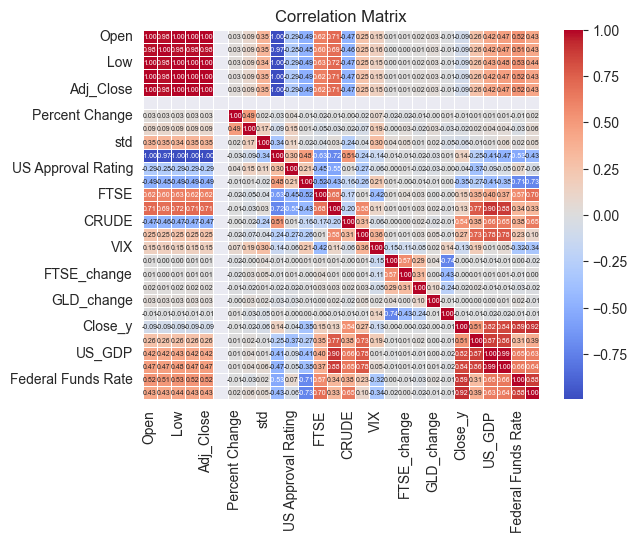

,Open,High,Low,Close_x,Adj_Close,Volume,Percent Change,ema,std,Inverse,...,FTSE_change,Crude_change,GLD_change,VIX_change,Close_y,GDP,US_GDP,CPI,Federal Funds Rate,10-Year Treasury Rate
Date,,,,,,,,,,,,,,,,,,,,,
2011-04-18 00:00:00+00:00,0.61275,0.61809,0.61244,0.61297,0.61297,0.0,-0.002766,-0.000625,0.004319,1.631987,...,-0.015711,-0.006129,0.014742,0.042409,3.47,NaN,NaN,NaN,NaN,NaN
2011-04-19 00:00:00+00:00,0.61482,0.61599,0.61220,0.61496,0.61496,0.0,0.003247,-0.000140,0.003872,1.626492,...,0.004565,-0.002302,0.000000,-0.066627,3.46,NaN,NaN,NaN,NaN,NaN
2011-04-20 00:00:00+00:00,0.61257,0.61286,0.60883,0.61258,0.61258,0.0,-0.003870,-0.000607,0.003898,1.632467,...,0.021265,0.000000,0.003906,-0.048010,3.48,NaN,NaN,NaN,NaN,NaN
2011-04-21 00:00:00+00:00,0.60997,0.61017,0.60244,0.60995,0.60995,0.0,-0.004293,-0.001069,0.003970,1.639425,...,-0.000664,0.021924,0.001638,-0.025216,3.44,NaN,NaN,NaN,NaN,NaN
2011-04-22 00:00:00+00:00,0.60540,0.60584,0.60372,0.60552,0.60552,0.0,-0.007263,-0.001844,0.004196,1.651800,...,0.000000,0.000000,0.000000,0.000000,3.44,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-17 00:00:00+00:00,0.80444,0.80530,0.80117,0.80444,0.80444,0.0,0.001319,0.001553,0.004448,1.243101,...,0.003529,-0.030327,-0.007368,-0.010326,4.26,3.141506e+12,28284.498,312.23,5.33,4.59
2024-04-18 00:00:00+00:00,0.80298,0.80400,0.80099,0.80297,0.80297,0.0,-0.001827,0.001131,0.004510,1.245361,...,0.003708,-0.002062,0.003415,-0.011532,4.28,3.141506e+12,28284.498,312.23,5.33,4.64
2024-04-19 00:00:00+00:00,0.80410,0.80697,0.80200,0.80401,0.80401,0.0,0.001295,0.001151,0.004488,1.243626,...,0.002387,0.002066,0.003132,0.039444,4.23,3.141506e+12,28284.498,312.23,5.33,4.62


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

#df_standardized.dropna(inplace=True)
# Using seaborn to create a heatmap
sns.heatmap(df_standardized.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 5})

# Add labels and a title, if desired
plt.title('Correlation Matrix')
plt.show()

df_standardized

In [16]:
import pandas as pd

df_standardized.index = df_standardized.index.tz_localize(None)
#df_standardized.to_excel('FA_data_set.xlsx', index=True)  # Set index=False to exclude the index column

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Example DataFrame loading (replace this with your actual data loading method)
# df = pd.read_csv('path_to_your_data.csv')

#df_standardized.drop("Volume", axis = 1, inplace=True)
#df_standardized["spread"] = df_standardized["Inverse"] - df_standardized["Open"]
df_standardized.dropna(inplace = True)
#df_standardized["spread"] = df["Inverse"] - df["Open"]
df_standardized["y"] = df_standardized["Open"].shift(-1)
df_standardized =df_standardized[:-1]
# Assuming 'TargetColumn' is the name of your target column
y = df_standardized['y']
X = df_standardized.drop('y', axis=1)  # This removes the target column from the feature set


"""
train_size = int(len(df_standardized) * 0.7)  # 70% of the data for training

# Split the data
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
"""
train_size = int(len(df_standardized) * 0.7)  # 70% of the data for training

# Split the data
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print((X_train))
print((X_test))

               Open     High      Low  Close_x  Adj_Close  Volume  \
Date                                                                
2017-07-13  0.77566  0.77575  0.77203  0.77557    0.77557     0.0   
2017-07-14  0.77230  0.77300  0.76370  0.77237    0.77237     0.0   
2017-07-17  0.76280  0.76621  0.76260  0.76270    0.76270     0.0   
2017-07-18  0.76620  0.76883  0.76197  0.76610    0.76610     0.0   
2017-07-19  0.76704  0.76846  0.76618  0.76695    0.76695     0.0   
...             ...      ...      ...      ...        ...     ...   
2022-04-06  0.76474  0.76648  0.76296  0.76468    0.76468     0.0   
2022-04-07  0.76501  0.76599  0.76297  0.76499    0.76499     0.0   
2022-04-08  0.76519  0.77013  0.76460  0.76515    0.76515     0.0   
2022-04-11  0.76749  0.76983  0.76584  0.76733    0.76733     0.0   
2022-04-12  0.76784  0.76941  0.76607  0.76780    0.76780     0.0   

            Percent Change       ema       std   Inverse  ...  FTSE_change  \
Date                    

In [146]:
# Create a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Mean squared error (MSE):", mse)
print("Coefficient of determination (R^2):", r2)

Coefficients: [-1.07009816e+00  7.76928950e-01  7.85609710e-01  2.84782951e-01
  2.84782951e-01 -9.80916737e-14  1.87316675e-02  8.00264944e-02
 -2.74054629e-02  4.33309204e-02  3.16954197e-03 -2.25080857e-03
 -2.67848351e-07 -7.22187845e-06 -6.58541707e-07 -2.68681266e-05
  1.74195500e-05 -5.68647511e-02  3.81755283e-02  2.56277041e-03
 -4.28257878e-02 -1.62541487e-03 -3.17681845e-04 -3.85313528e-16
 -1.22929244e-07  8.97284469e-05 -2.81448466e-05 -2.93787066e-04]
Intercept: -0.11572930860819308
Mean squared error (MSE): 8.917335562403581e-06
Coefficient of determination (R^2): 0.9898441034522358


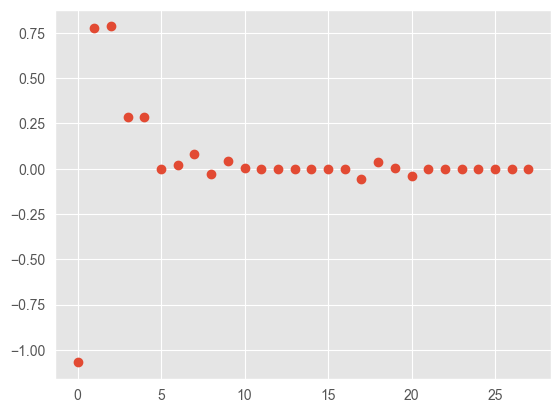

In [147]:
plt.plot(model.coef_, marker = "o", linestyle = "")

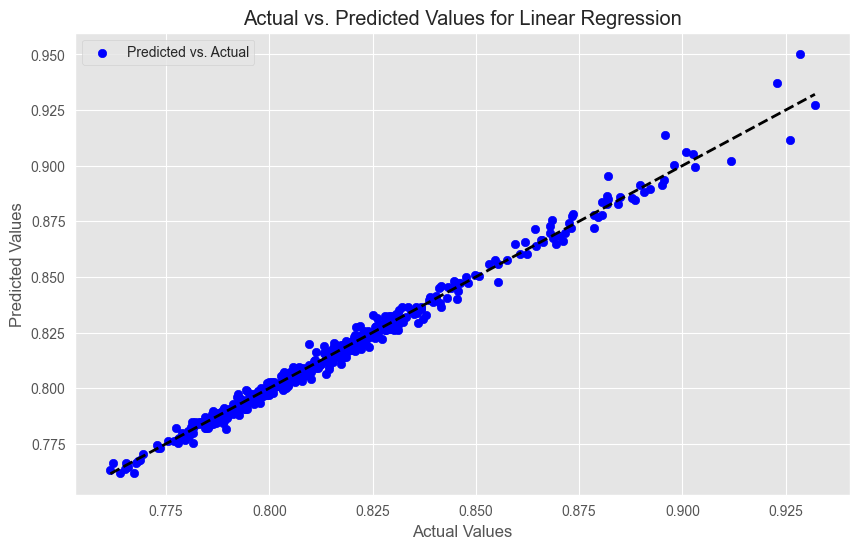

In [148]:
# Actual vs. Predicted scatter plot
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs. Actual')  # Scatter plot of actual vs predicted
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values for Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

In [149]:
count = 0
pre_act, pre_pred = 0, 0
for actual, predicted in zip(y_test, y_pred):
    if (actual >  pre_act and predicted > pre_pred) or (actual < pre_act and predicted < pre_pred):
        count += 1
    pre_act, pre_pred = actual, predicted
        
# Calculate the proportion of matching signs
matching_sign_proportion = count / len(y_test)
print("Proportion of matching signs:", matching_sign_proportion)

Proportion of matching signs: 0.7395437262357415


In [150]:
for i, item in enumerate(y_test):
    if i ==0: continue
    print("Pred:", y_pred[i] - y_pred[i-1], ", Real:", item - y_test[i-1])

Pred: -0.0011088730602862862 , Real: 0.0035300254821777344
Pred: -0.0005561190400691363 , Real: 0.00022995471954345703
Pred: 0.0029342519557353786 , Real: 0.002950012683868408
Pred: -9.205196221750978e-05 , Real: -0.0004799962043762207
Pred: -0.001128597752767302 , Real: -0.003080010414123535
Pred: 0.00022374299808547438 , Real: 0.002590000629425049
Pred: 0.010103424798670324 , Real: 0.01166999340057373
Pred: 0.008824704003469241 , Real: 0.005620002746582031
Pred: 0.005382256622106785 , Real: 0.00953000783920288
Pred: 0.0077528721397143174 , Real: 0.002839982509613037
Pred: 0.002552098372960887 , Real: 0.004580020904541016
Pred: -0.0024164880209196493 , Real: -0.0021200180053710938
Pred: -0.0016368183010458948 , Real: 0.0001100301742553711
Pred: 0.00030397522005509714 , Real: -0.007579982280731201
Pred: 0.01069990544479471 , Real: 0.016179978847503662
Pred: 0.004648789625848471 , Real: 0.002460002899169922
Pred: -0.000469076529534318 , Real: -0.00038999319076538086
Pred: -0.00096360689

In [151]:
def backtest(df, real, preds, capital, cur):
    position = [(capital, cur)]
    cap = [capital]
    long, short = [], []
    # 0, represents our capital is in USD
    # 1, represents our capital in EUR
    for i in range(len(real)):
        if i < len(real) - 1:
            spread = np.random.uniform(0.0014, 0.015)
            if preds[i] > real[i-1] and preds[i] - real[i-1] > spread:
                rtrn = cap[-1] * (((real[i] - spread)/real[i-1]) - 1)
                print("Long")
                print("Difference:", real[i] - real[i-1])
                print("Spread:", spread, "\n")
                long.append(((real[i] - spread)/real[i-1]) - 1)
                position.append(((cap[-1] + (rtrn)), 0))
            if preds[i] < real[i-1] and real[i-1] - preds[i] > spread:
                rtrn = cap[-1] * (1 - ((real[i] + spread)/real[i-1]))
                print("Short:")
                print("Difference:", real[i-1] - real[i])
                print("Spread:", spread, "\n")
                position.append(((cap[-1] + (rtrn)), 1))
                short.append(((real[i] - spread)/real[i-1]) - 1)
            cap.append(position[-1][0])
            
    return cap, position, long, short
        
cap, positions, long, short = backtest(df[train_size:], y_test, y_pred, 100, 0)

for i in range(len(positions)):
    print(i, ":", positions[i])

Short:
Difference: 0.04764002561569214
Spread: 0.0104157919478451 

Long
Difference: 0.01166999340057373
Spread: 0.007799632807751192 

Long
Difference: 0.002839982509613037
Spread: 0.0015955481085917684 

Long
Difference: 0.004580020904541016
Spread: 0.001848431614860909 

Long
Difference: 0.016179978847503662
Spread: 0.0076549131884125765 

Short:
Difference: 0.010609984397888184
Spread: 0.006792850115997354 

Long
Difference: 0.008990049362182617
Spread: 0.00363344355519387 

Long
Difference: 0.008949995040893555
Spread: 0.0038322360435874324 

Long
Difference: 0.008080005645751953
Spread: 0.002129999984100424 

Long
Difference: 0.005430042743682861
Spread: 0.0018562726504198054 

Long
Difference: 0.003679990768432617
Spread: 0.0019540402083916344 

Long
Difference: 0.0009799599647521973
Spread: 0.0022167420178707334 

Long
Difference: 0.008240044116973877
Spread: 0.007278327456278713 

Short:
Difference: 0.004419982433319092
Spread: 0.004481862265001078 

Long
Difference: 0.0013400

[*********************100%%**********************]  1 of 1 completed


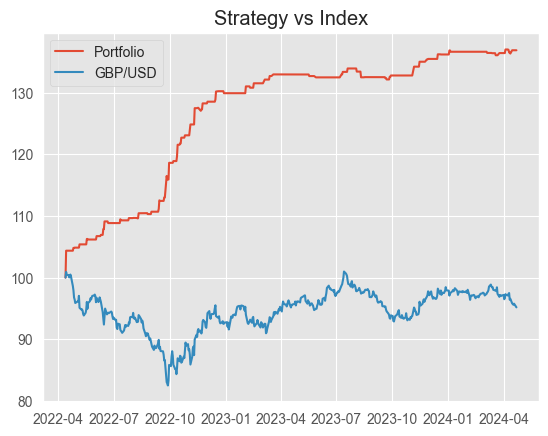

In [121]:
SPY = yf.download("SPY", start = y_test.index[0])["Open"]
SPY = (SPY / SPY[0]) * 100

plt.plot(y_test.index[:], cap[:], label = "Portfolio")
#plt.plot(y_test.index[:-4], SPY[:], label = "SPY")
#plt.plot(y_test.index[:], (df["Open"][train_size:-1] / df["Open"][train_size]) * 100, label = "USD/GBP")
plt.plot(y_test.index[:], (df["Inverse"][train_size:-1] / df["Inverse"][train_size]) * 100, label = "GBP/USD")
plt.title("Strategy vs Index")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Histogram of Returns')

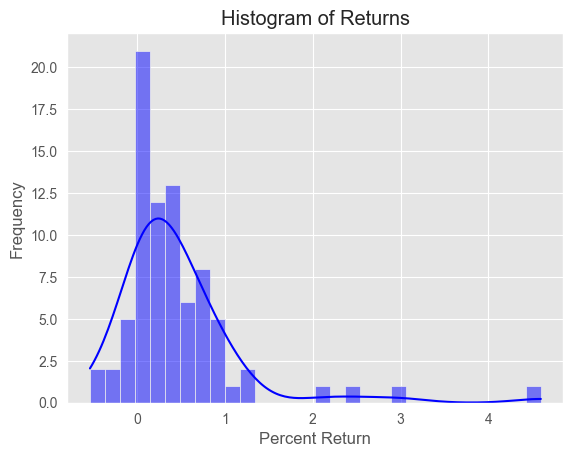

In [153]:
returns = pd.Series(cap).pct_change()

mask = returns != 0

# Apply the mask to filter out zero values
filtered_data = (returns[mask] * 100).dropna()
# Display the filtered Series
sns.histplot(filtered_data, kde=True, bins = 30, color = "blue")
plt.xlabel("Percent Return")
plt.ylabel("Frequency")
plt.title("Histogram of Returns")

In [107]:
print(np.mean(filtered_data) * 39.84)
print(np.std(filtered_data) * np.sqrt(39.84))
print(np.mean(filtered_data) * 39.84 / (np.std(filtered_data) * np.sqrt(39.84)))

15.688413432419473
3.6348480401822543
4.316112601954288


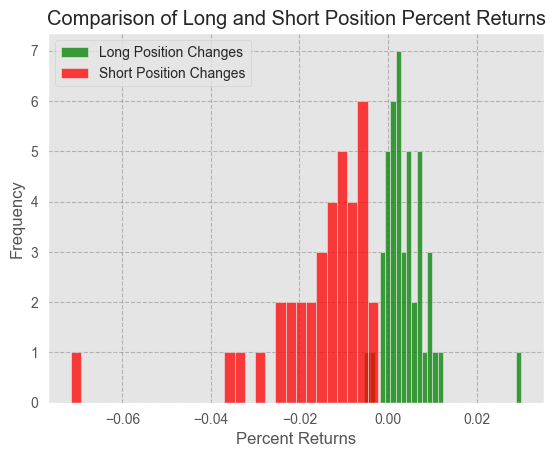

In [154]:
import matplotlib.pyplot as plt
import numpy as np

# Optionally set a style
plt.style.use('ggplot')

# Create histograms
plt.hist(long, bins=30, alpha=0.75, label="Long Position Changes", color="green")
plt.hist(short, bins=30, alpha=0.75, label="Short Position Changes", color="red")

# Add labels and title
plt.xlabel('Percent Returns')
plt.ylabel('Frequency')
plt.title('Comparison of Long and Short Position Percent Returns')

# Add a grid for better readability
plt.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# Add a legend
plt.legend()

# Show the plot
plt.show()

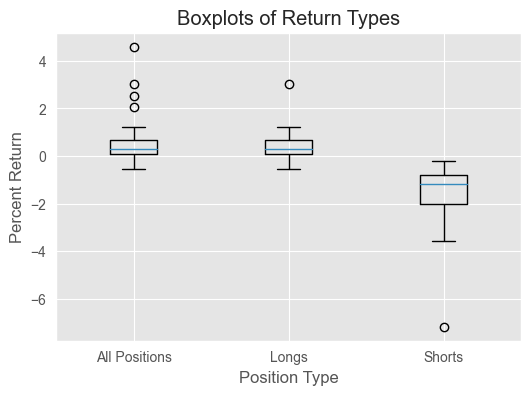

In [155]:
plt.figure(figsize=(6, 4))

# Create the boxplots
plt.boxplot([filtered_data, pd.Series(long) * 100, pd.Series(short) * 100], labels=["All Positions", "Longs", "Shorts"])

# Customize the plot
plt.title('Boxplots of Return Types')
plt.xlabel('Position Type')
plt.ylabel('Percent Return')

# Display the plot
plt.grid(True)
plt.show()

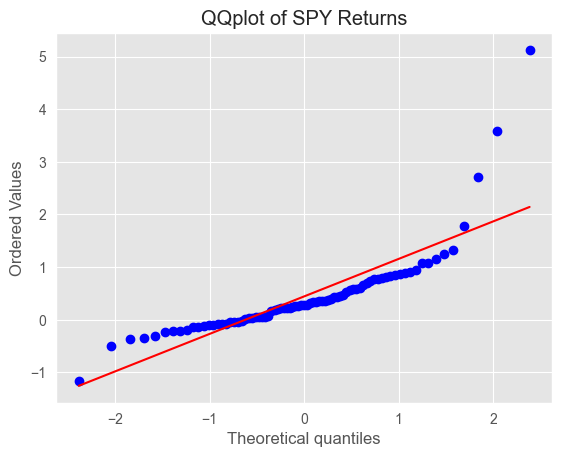

In [28]:
import scipy.stats as stats
import pylab

stats.probplot(filtered_data.dropna(), dist="norm", plot = pylab)
pylab.title("QQplot of SPY Returns")
pylab.show()

ShapiroResult(statistic=0.8115288615226746, pvalue=4.305115453462349e-06)
SignificanceResult(statistic=205.07062461182883, pvalue=2.9476754563038877e-45) 


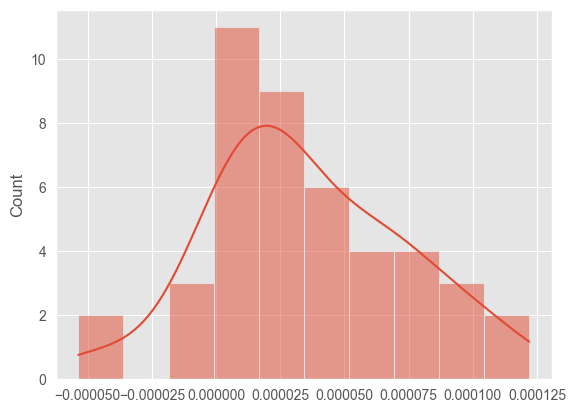

ShapiroResult(statistic=0.9809461832046509, pvalue=0.6714513897895813)
SignificanceResult(statistic=0.3270746181088043, pvalue=0.8491348179934741) 

ShapiroResult(statistic=0.7496071457862854, pvalue=1.87680905128218e-06)
SignificanceResult(statistic=156.18324006172975, pvalue=1.216859221843488e-34) 


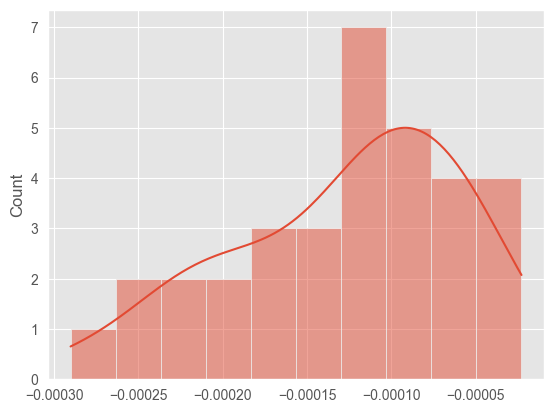

ShapiroResult(statistic=0.9473367929458618, pvalue=0.11121650040149689)
SignificanceResult(statistic=2.40149904894567, pvalue=0.3009685440616508) 

ShapiroResult(statistic=0.7093974947929382, pvalue=2.2736600796546824e-11)
SignificanceResult(statistic=711.648857005189, pvalue=2.9336896923997644e-155) 


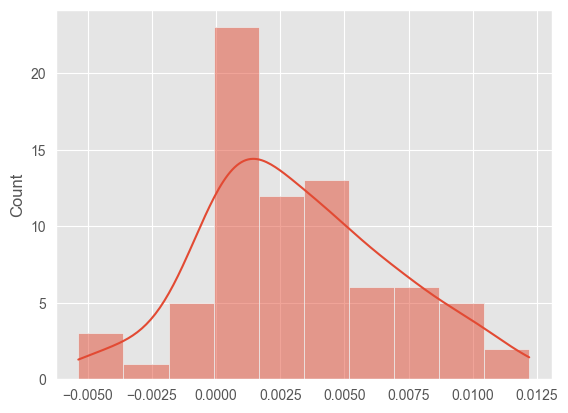

ShapiroResult(statistic=0.9797108173370361, pvalue=0.26374614238739014)
SignificanceResult(statistic=1.073910260654285, pvalue=0.5845253489953688) 


In [158]:
from scipy.stats import shapiro, jarque_bera
import seaborn as sns

def normality_test(data):
    # Calculate IQR
    data = data.tolist()
    q25 = np.percentile(data, 25)
    q75 = np.percentile(data, 75)
    iqr = (q75 - q25) * 1.5
    
    test_result = shapiro(data)
    res = jarque_bera(data)
    print(test_result)
    print(res, "\n")
    
    """
    test_result = shapiro(data)
    res = jarque_bera(data)
    print(test_result)
    print(res, "\n")
    
    sns.histplot(data, kde=True)
    plt.show()
    """
    
    for i, item in enumerate(data):
        if item < np.mean(data) - iqr or item > np.mean(data) + iqr: data.pop(i)

    # Optional: Visualize the data
    sns.histplot(data, kde=True, bins = 10)
    plt.show()

    # Perform and print the normality test results
    test_result = shapiro(data)
    res = jarque_bera(data)
    print(test_result)
    print(res, "\n")
    return [item * 100 for item in data]

    
filtered_long = normality_test(np.log1p(pd.Series(long) / 100))
filtered_short = normality_test(np.log1p(pd.Series(short) / 100))
filtered_returns = normality_test((filtered_data / 100))

In [159]:
import numpy as np 
from scipy.stats import norm 
from scipy.optimize import minimize 

def log_likelihood(params, data): 
     mean, std = params 
     return np.sum(norm.logpdf(data, mean, std)) 

def mle(data):
    initial_params = [np.mean(data), np.std(data)]
    
    
    # minimize the negative log-likelihood
    result = minimize(lambda params: -log_likelihood(params, data), initial_params)


    # extract the estimated parameters
    mean, std = result.x
    
    print(mean)
    print(std, "\n")

mle(filtered_long)
mle(filtered_short)
mle(filtered_returns)

-23.252325149339764
-46.50596605291905 

-5.616231336160946
-11.19837428696293 

0.3174203331859616
0.3653715896257899 


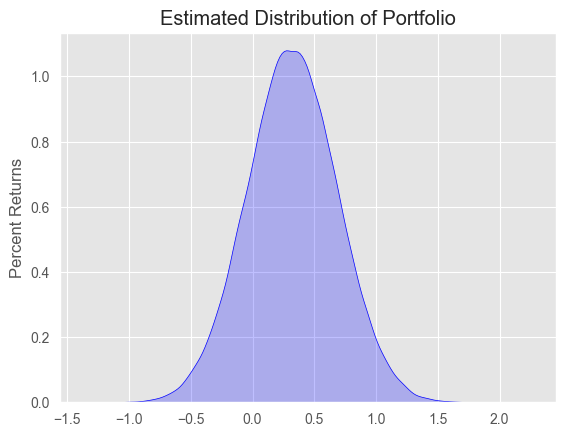

-0.5289774335734251

In [160]:
port = np.random.normal(0.3174203331859616, 0.3653715896257899 , 100000)
sns.kdeplot(port, color = "blue", fill = True)
plt.ylabel("Percent Returns")
plt.title("Estimated Distribution of Portfolio")
plt.show()
np.percentile(port, 1)

In [163]:
SPY = (yf.download("SPY", start = "2022-04-01")["Adj Close"]).pct_change().dropna()

[*********************100%%**********************]  1 of 1 completed


Text(0.5, 1.0, 'Histogram of SPY Returns')

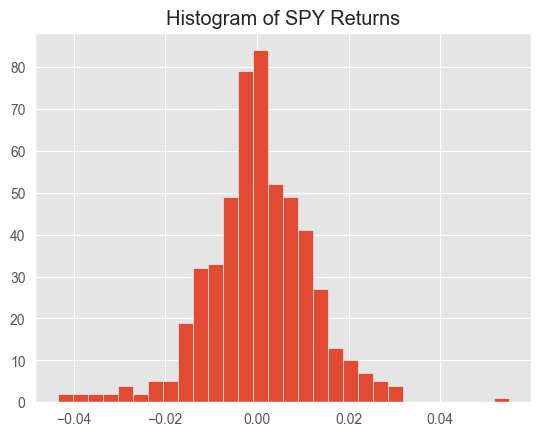

In [164]:
plt.hist(SPY, bins = 30)
plt.title("Histogram of SPY Returns")

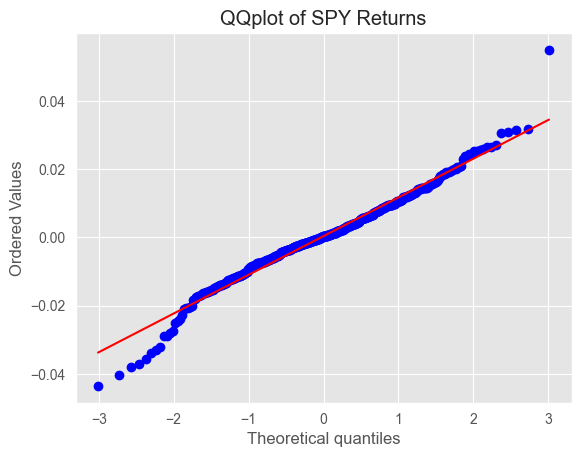

In [165]:
import scipy.stats as stats
import pylab

stats.probplot(SPY, dist="norm", plot = pylab)
pylab.title("QQplot of SPY Returns")
pylab.show()

In [166]:
print(shapiro(SPY))
print(jarque_bera(SPY))
print("\n", shapiro(filtered_data))
jarque_bera(filtered_data)

ShapiroResult(statistic=0.9766356348991394, pvalue=1.7797709972455777e-07)
SignificanceResult(statistic=86.27458145164213, pvalue=1.8437951723542525e-19)

 ShapiroResult(statistic=0.7093973755836487, pvalue=2.2736455079774842e-11)


SignificanceResult(statistic=711.6488570051904, pvalue=2.933689692397757e-155)

ShapiroResult(statistic=0.9995151162147522, pvalue=0.2371234893798828)
ShapiroResult(statistic=0.9994694590568542, pvalue=0.1705714613199234)
SignificanceResult(statistic=2.4649146603223246, pvalue=0.29157520009162247)
SignificanceResult(statistic=2.6698332888675074, pvalue=0.2631801120690129)


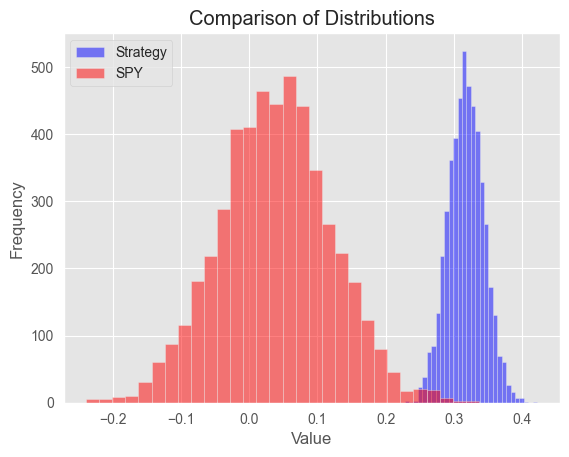

In [169]:
port, spy = [], []
for i in range(4999):
    port.append(np.mean(pd.Series((filtered_returns)).sample(n=200, replace = True)))
    spy.append(np.mean((SPY).sample(n=200, replace = True)))
    
print(shapiro(port))
print(shapiro(spy))
print(jarque_bera(port))
print(jarque_bera(spy))

plt.hist(port, bins=30, alpha=0.5, label='Strategy', color = "blue")
plt.hist(pd.Series(spy) * 100, bins=30, alpha=0.5, label='SPY', color = "red")

# Adding labels
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title("Comparison of Distributions")

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [170]:
print(np.mean(pd.Series(spy) * 100))
print(np.std(pd.Series(spy)*100))
print(np.mean(port))
print(np.std(port))

0.038549304879700146
0.08181240387730015
0.31712651940076236
0.026025413134015834


In [171]:
import scipy.stats as stats

t_stat, p_value = stats.ttest_ind(port, spy, equal_var=False)

if t_stat > 0:
    one_sided_p_value = p_value / 2
else:
    one_sided_p_value = 1 - (p_value / 2)

print("T-statistic:", t_stat)
print("One-sided P-value:", one_sided_p_value)

T-statistic: 859.983928484121
One-sided P-value: 0.0


In [39]:
print(np.mean(port))
np.mean(spy)

0.44296225391114313


0.0003905916019387366

In [40]:
print(np.mean(filtered_data) * 252)
print(np.std(filtered_data) * np.sqrt(252))
print(((np.mean(filtered_data) * 252))/ (np.std(filtered_data) * np.sqrt(252)))

111.86575796530603
13.158398128338348
8.501472358127572


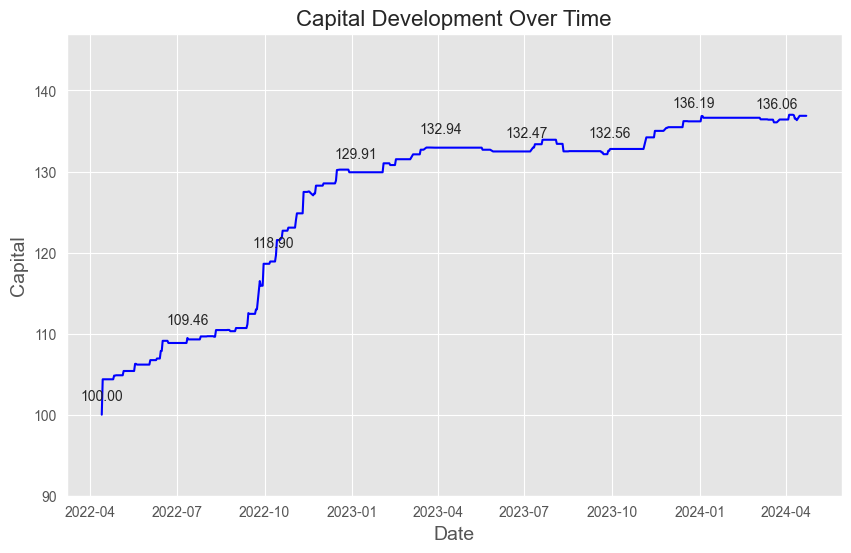

In [109]:
import matplotlib.pyplot as plt

# Sample Data
# y_test.index would be your index for the test data
# capital is an array or list of values you want to plot

# Start plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(y_test.index, cap, color='blue', linestyle='-')  # Basic line plot with markers

# Customizations
plt.title('Capital Development Over Time', fontsize=16)  # Add a title
plt.xlabel('Date', fontsize=14)  # Label the x-axis
plt.ylabel('Capital', fontsize=14)  # Label the y-axis

plt.grid(True)  # Show grid

# Annotations
critical_points = [(y_test.index[i], cap[i]) for i in range(len(cap)) if i % 63 == 0]  # Example: annotate every 10th point
for point in critical_points:
    plt.annotate(f'{point[1]:.2f}', (point[0], point[1]), textcoords="offset points", xytext=(0,10), ha='center')

# Axis limits (optional)
plt.ylim(min(cap) - 10, max(cap) + 10)  # Setting y-axis limits

# Save plot (optional)
#plt.savefig('fancy_plot.png', dpi=300)  # Save the plot as a PNG file

plt.show()  # Display the plot

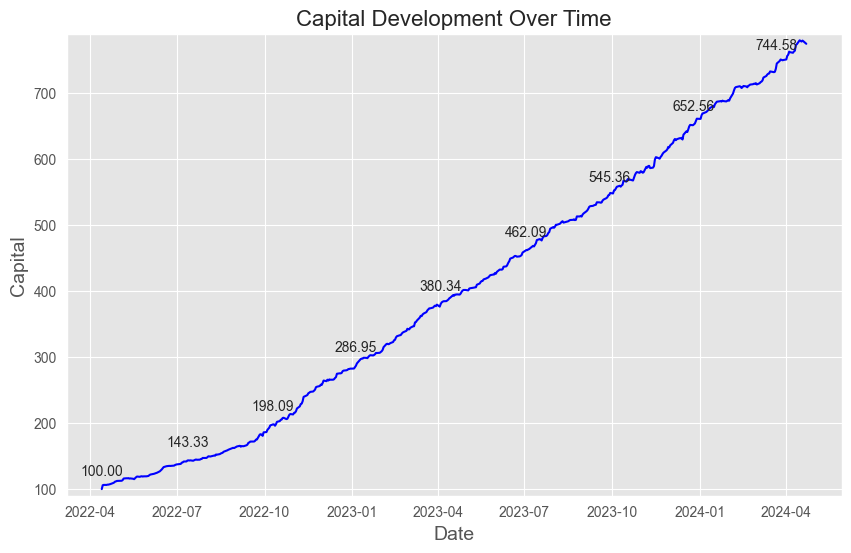

In [94]:
import matplotlib.pyplot as plt

# Sample Data
# y_test.index would be your index for the test data
# capital is an array or list of values you want to plot

# Start plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(y_test.index, cap2, color='blue', linestyle='-')  # Basic line plot with markers

# Customizations
plt.title('Capital Development Over Time', fontsize=16)  # Add a title
plt.xlabel('Date', fontsize=14)  # Label the x-axis
plt.ylabel('Capital', fontsize=14)  # Label the y-axis

plt.grid(True)  # Show grid

# Annotations
critical_points = [(y_test.index[i], cap2[i]) for i in range(len(cap2)) if i % 63 == 0]  # Example: annotate every 10th point
for point in critical_points:
    plt.annotate(f'{point[1]:.2f}', (point[0], point[1]), textcoords="offset points", xytext=(0,10), ha='center')

# Axis limits (optional)
plt.ylim(min(cap2) - 10, max(cap2) + 10)  # Setting y-axis limits

# Save plot (optional)
#plt.savefig('fancy_plot.png', dpi=300)  # Save the plot as a PNG file

plt.show()  # Display the plot

In [97]:
fake_returns = pd.Series(cap2).pct_change()

mask = fake_returns != 0

# Apply the mask to filter out zero values
filtered_data = (returns[mask] * 100).dropna()

print(np.mean(filtered_data) * 252)
print(np.std(filtered_data) * np.sqrt(252))
print(np.mean(filtered_data) * 252 / np.std(filtered_data) * np.sqrt(252))

13.531723837155088
5.288788463185606
644.7590843724414


In [62]:
lasso = Lasso(alpha=0.1)

# Fit the model
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean squared error (MSE):", mse)
print("Coefficient of determination (R^2):", r2)

Mean squared error (MSE): 0.004069381057080407
Coefficient of determination (R^2): -3.6345921088115114


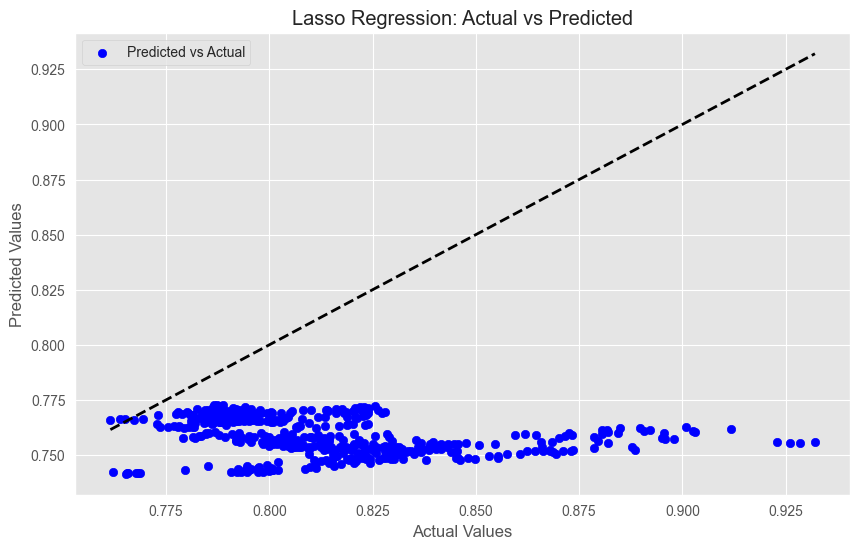

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Lasso Regression: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


In [66]:
count = 0
pre_act, pre_pred = 0, 0
for actual, predicted in zip(y_test, y_pred):
    if (actual > pre_act and predicted > pre_pred) or (actual < pre_act and predicted < pre_pred):
        count += 1
    pre_act, pre_pred = actual, predicted
        
# Calculate the proportion of matching signs
matching_sign_proportion = count / len(y_test)
print("Proportion of matching signs:", matching_sign_proportion)

Proportion of matching signs: 0.5608365019011406


In [68]:
def backtest(df, real, preds, capital, cur):
    position = [(capital, cur)]
    cap = [capital]
    long, short = [], []
    # 0, represents our capital is in USD
    # 1, represents our capital in EUR
    for i in range(len(real)):
        if i < len(real) - 1:
            spread = np.random.uniform(0.0014, 0.015)
            if preds[i] > real[i-1] and preds[i] - real[i-1] > spread:
                rtrn = cap[-1] * (((real[i] - spread)/real[i-1]) - 1)
                print("Long")
                print("Difference:", real[i] - real[i-1])
                print("Spread:", spread, "\n")
                long.append(((real[i] - spread)/real[i-1]) - 1)
                position.append(((cap[-1] + (rtrn)), 0))
            if preds[i] < real[i-1] and real[i-1] - preds[i] > spread:
                rtrn = cap[-1] * (1 - ((real[i] + spread)/real[i-1]))
                print("Short:")
                print("Difference:", real[i-1] - real[i])
                print("Spread:", spread, "\n")
                position.append(((cap[-1] + (rtrn)), 1))
                short.append(((real[i] - spread)/real[i-1]) - 1)
            cap.append(position[-1][0])
            
    return cap, position, long, short
        
cap, positions, long, short = backtest(df[train_size:], y_test, y_test, 100, 0)

for i in range(len(positions)):
    print(i, ":", positions[i])

Short:
Difference: 0.04764002561569214
Spread: 0.0124959486403782 

Long
Difference: 0.01166999340057373
Spread: 0.011594452789718332 

Long
Difference: 0.00953000783920288
Spread: 0.007942078117459032 

Long
Difference: 0.004580020904541016
Spread: 0.004563121213783283 

Long
Difference: 0.016179978847503662
Spread: 0.008193476100251644 

Short:
Difference: 0.0038200020790100098
Spread: 0.0017643498536526678 

Long
Difference: 0.009259998798370361
Spread: 0.007238934268873742 

Short:
Difference: 0.0038700103759765625
Spread: 0.0022675046408595547 

Short:
Difference: 0.005959987640380859
Spread: 0.0027478137735486297 

Long
Difference: 0.0056999921798706055
Spread: 0.0026890183039975056 

Long
Difference: 0.014059960842132568
Spread: 0.006833312946229012 

Short:
Difference: 0.01148003339767456
Spread: 0.011100896576679814 

Short:
Difference: 0.011219978332519531
Spread: 0.006346718715458016 

Long
Difference: 0.008080005645751953
Spread: 0.0032858474914604857 

Long
Difference: 0.0

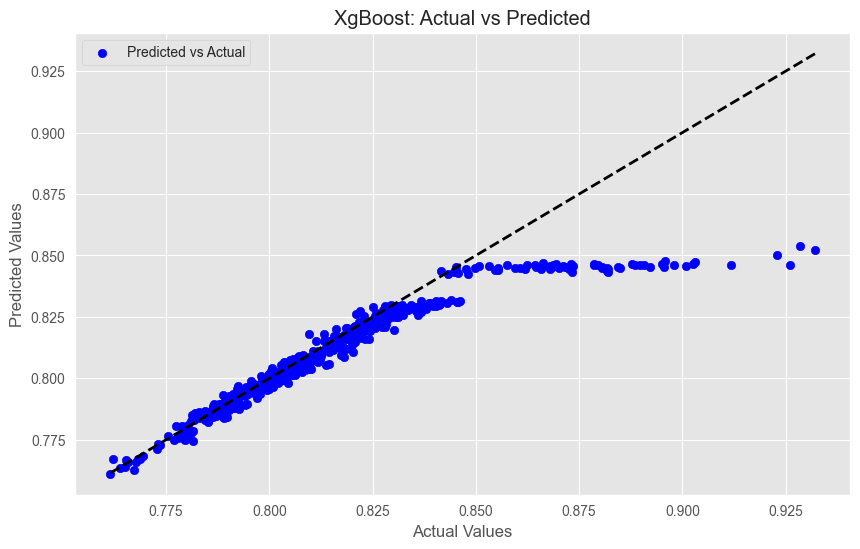

MSE: 0.00016891096978591057
R2: 0.8076283747624442


In [122]:
import xgboost as xgb

param_grid = {
        'max_depth': list(range(10, 1001, 20)),  # Max depth of trees
        'learning_rate': [i / 100 for i in range(1, 100, 5)],
        'n_estimators': list(range(10, 1001, 20)),
        'subsample': [i / 100 for i in range(60, 101, 5)],
        'colsample_bytree': [i / 100 for i in range(60, 101, 5)],
        'colsample_bylevel': [i / 100 for i in range(60, 101, 5)],
        'min_child_weight': list(range(0, 51, 5))
    }
    #"""
    # Create an XGBoost regressor model, uses squared error as the error parameter
model = xgb.XGBRegressor(objective="reg:squarederror", 
                         validate_parameters=True, 
                         early_stopping_rounds=20,
                         tree_method = 'exact')

# Create a GridSearchCV object
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,  # Use param_grid instead of param_distributions
    scoring="neg_mean_squared_error",  # Choose an appropriate scoring metric
    cv=5,  # Number of cross-validation folds
    verbose=0,
    n_jobs=-1,  # Use all available CPU cores
    n_iter=100
)

try:
    random_search.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train)], 
                    verbose=False
                    )
except ValueError:
    print("FUCK")

# Get the best hyperparameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_
#best_model.save_model("301-model.json")

# Make predictions with the best model
prediction = best_model.predict(X_test)

#xgb.plot_importance(best_model)
#plt.show()

# Calculate the mean squared error
mse = mean_squared_error(y_test, prediction)
r2 = r2_score(y_test, prediction)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, prediction, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XgBoost: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()
# Print the best hyperparameters and MSE
#print("Best Hyperparameters:", best_params)
print("MSE:", mse)
print("R2:", r2)

In [123]:
count = 0
pre_act, pre_pred = 0, 0
for actual, predicted in zip(y_test, prediction):
    if (actual > pre_act and predicted > pre_pred) or (actual < pre_act and predicted < pre_pred):
        count += 1
    pre_act, pre_pred = actual, predicted
        
# Calculate the proportion of matching signs
matching_sign_proportion = count / len(y_test)
print("Proportion of matching signs:", matching_sign_proportion)

Proportion of matching signs: 0.6996197718631179


In [133]:
def backtest(df, real, preds, capital, cur):
    position = [(capital, cur)]
    cap = [capital]
    long, short = [], []
    # 0, represents our capital is in USD
    # 1, represents our capital in EUR
    for i in range(len(real)):
        if i < len(real) - 1:
            spread = np.random.uniform(0.0014, 0.015)
            if preds[i] > real[i-1] and preds[i] - real[i-1] > spread:
                rtrn = cap[-1] * (((real[i] - spread)/real[i-1]) - 1)
                print("Long")
                print("Difference:", real[i] - real[i-1])
                print("Spread:", spread, "\n")
                long.append(((real[i] - spread)/real[i-1]) - 1)
                position.append(((cap[-1] + (rtrn)), 0))
            if preds[i] < real[i-1] and real[i-1] - preds[i] > spread:
                rtrn = cap[-1] * (1 - ((real[i] + spread)/real[i-1]))
                print("Short:")
                print("Difference:", real[i-1] - real[i])
                print("Spread:", spread, "\n")
                position.append(((cap[-1] + (rtrn)), 1))
                short.append(((real[i] - spread)/real[i-1]) - 1)
            cap.append(position[-1][0])
            
    return cap, position, long, short
        
cap, positions, long, short = backtest(df[train_size:], y_test, prediction, 100, 0)

for i in range(len(positions)):
    print(i, ":", positions[i])

Short:
Difference: 0.04764002561569214
Spread: 0.011057928782750874 

Short:
Difference: 0.0004799962043762207
Spread: 0.001473688017926356 

Long
Difference: 0.016179978847503662
Spread: 0.004045321511867411 

Short:
Difference: 0.010609984397888184
Spread: 0.0036737899017720253 

Short:
Difference: 0.01148003339767456
Spread: 0.004999145581763459 

Short:
Difference: -0.0021499991416931152
Spread: 0.002735872016468489 

Short:
Difference: 0.007879972457885742
Spread: 0.0015562165688304665 

Short:
Difference: -0.0012199878692626953
Spread: 0.003494192104326375 

Short:
Difference: 0.003500044345855713
Spread: 0.00738282841266509 

Short:
Difference: 0.004419982433319092
Spread: 0.005289328021415949 

Short:
Difference: 0.00372999906539917
Spread: 0.004320083210007035 

Short:
Difference: 0.009510040283203125
Spread: 0.008246585432514972 

Short:
Difference: -0.0010899901390075684
Spread: 0.001415669331190576 

Short:
Difference: 0.0025600194931030273
Spread: 0.01256291659429023 

Sho

In [127]:
def backtest(df, real, preds, capital, cur):
    position = [(capital, cur)]
    cap = [capital]
    long, short = [], []
    # 0, represents our capital is in USD
    # 1, represents our capital in EUR
    for i in range(len(real)):
        if i < len(real) - 1:
            spread = 0
            if preds[i] > real[i-1] and preds[i] - real[i-1] > spread:
                rtrn = cap[-1] * (((real[i] - spread)/real[i-1]) - 1)
                print("Long")
                print("Difference:", real[i] - real[i-1])
                print("Spread:", spread, "\n")
                long.append(((real[i] - spread)/real[i-1]) - 1)
                position.append(((cap[-1] + (rtrn)), 0))
            if preds[i] < real[i-1] and real[i-1] - preds[i] > spread:
                rtrn = cap[-1] * (1 - ((real[i] + spread)/real[i-1]))
                print("Short:")
                print("Difference:", real[i-1] - real[i])
                print("Spread:", spread, "\n")
                position.append(((cap[-1] + (rtrn)), 1))
                short.append(((real[i] - spread)/real[i-1]) - 1)
            cap.append(position[-1][0])
            
    return cap, position, long, short
        
cap, positions, long, short = backtest(df[train_size:], y_test, prediction, 100, 0)

for i in range(len(positions)):
    print(i, ":", positions[i])

Short:
Difference: 0.04764002561569214
Spread: 0 

Long
Difference: 0.0035300254821777344
Spread: 0 

Long
Difference: 0.00022995471954345703
Spread: 0 

Long
Difference: 0.002950012683868408
Spread: 0 

Short:
Difference: 0.0004799962043762207
Spread: 0 

Short:
Difference: 0.003080010414123535
Spread: 0 

Long
Difference: 0.002590000629425049
Spread: 0 

Long
Difference: 0.01166999340057373
Spread: 0 

Long
Difference: 0.005620002746582031
Spread: 0 

Long
Difference: 0.00953000783920288
Spread: 0 

Long
Difference: 0.002839982509613037
Spread: 0 

Long
Difference: 0.004580020904541016
Spread: 0 

Short:
Difference: 0.0021200180053710938
Spread: 0 

Short:
Difference: -0.0001100301742553711
Spread: 0 

Short:
Difference: 0.007579982280731201
Spread: 0 

Long
Difference: 0.016179978847503662
Spread: 0 

Long
Difference: 0.002460002899169922
Spread: 0 

Short:
Difference: 0.00038999319076538086
Spread: 0 

Short:
Difference: -0.0018000006675720215
Spread: 0 

Short:
Difference: -0.0048

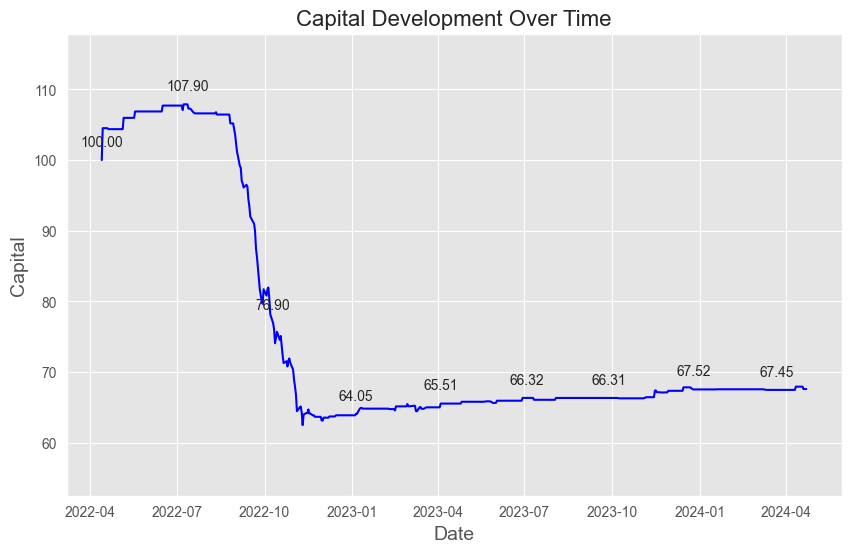

In [134]:
import matplotlib.pyplot as plt

# Sample Data
# y_test.index would be your index for the test data
# capital is an array or list of values you want to plot

# Start plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(y_test.index, cap, color='blue', linestyle='-')  # Basic line plot with markers

# Customizations
plt.title('Capital Development Over Time', fontsize=16)  # Add a title
plt.xlabel('Date', fontsize=14)  # Label the x-axis
plt.ylabel('Capital', fontsize=14)  # Label the y-axis

plt.grid(True)  # Show grid

# Annotations
critical_points = [(y_test.index[i], cap[i]) for i in range(len(cap)) if i % 63 == 0]  # Example: annotate every 10th point
for point in critical_points:
    plt.annotate(f'{point[1]:.2f}', (point[0], point[1]), textcoords="offset points", xytext=(0,10), ha='center')

# Axis limits (optional)
plt.ylim(min(cap) - 10, max(cap) + 10)  # Setting y-axis limits

# Save plot (optional)
#plt.savefig('fancy_plot.png', dpi=300)  # Save the plot as a PNG file

plt.show()  # Display the plot

In [135]:
fake_returns = pd.Series(cap).pct_change()

mask = fake_returns != 0

# Apply the mask to filter out zero values
filtered_data = (returns[mask] * 100).dropna()

print(np.mean(filtered_data) * 57.12)
print(np.std(filtered_data) * np.sqrt(57.12))

39.42759507558506
6.858947345026794


In [71]:
import matplotlib.pyplot as plt

# Sample Data
# y_test.index would be your index for the test data
# capital is an array or list of values you want to plot

# Start plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(y_test.index, position, color='blue', linestyle='-')  # Basic line plot with markers

# Customizations
plt.title('Capital Development Over Time', fontsize=16)  # Add a title
plt.xlabel('Date', fontsize=14)  # Label the x-axis
plt.ylabel('Capital', fontsize=14)  # Label the y-axis

plt.grid(True)  # Show grid

# Annotations
critical_points = [(y_test.index[i], position[i]) for i in range(len(position)) if i % 63 == 0]  # Example: annotate every 10th point
for point in critical_points:
    plt.annotate(f'{point[1]:.2f}', (point[0], point[1]), textcoords="offset points", xytext=(0,10), ha='center')

# Axis limits (optional)
plt.ylim(min(position) - 10, max(position) + 10)  # Setting y-axis limits

# Save plot (optional)
#plt.savefig('fancy_plot.png', dpi=300)  # Save the plot as a PNG file

plt.show()  # Display the plot

NameError: name 'position' is not defined

<Figure size 1000x600 with 0 Axes>

In [77]:
from sklearn.preprocessing import PolynomialFeatures

# Choose a degree for the polynomial features (e.g., 2 for quadratic, 3 for cubic, etc.)
degree = 2  # for quadratic polynomial features

# Create polynomial features
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
X_poly_train = poly_features.fit_transform(X_train)
X_poly_test = poly_features.transform(X_test)


In [78]:
# Create a linear regression model
poly_model = LinearRegression()

# Fit the model on the polynomially transformed training data
poly_model.fit(X_poly_train, y_train)

# Predict using the polynomially transformed test data
y_poly_pred = poly_model.predict(X_poly_test)


In [79]:
# Calculate mean squared error and R-squared
mse = mean_squared_error(y_test, y_poly_pred)
r2 = r2_score(y_test, y_poly_pred)

print(f"Mean squared error: {mse}")
print(f"R-squared: {r2}")


Mean squared error: 0.0007718791216180422
R-squared: 0.1209117957181629


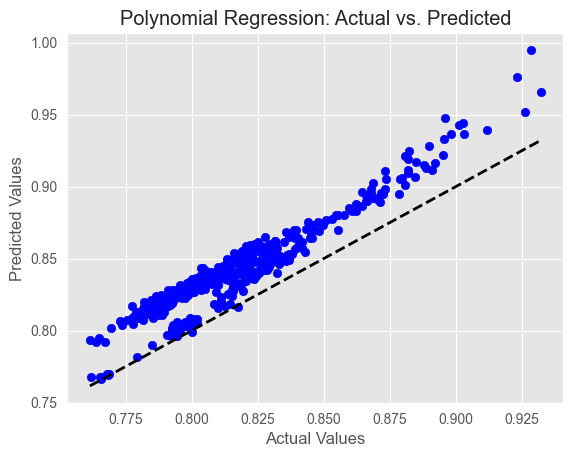

In [80]:
# Plotting actual vs predicted values for multi-dimensional data
plt.scatter(y_test, y_poly_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Polynomial Regression: Actual vs. Predicted')
plt.show()


In [81]:
count = 0
pre_act, pre_pred = 0, 0
for actual, predicted in zip(y_test, y_poly_pred):
    if (actual > pre_act and predicted > pre_pred) or (actual < pre_act and predicted < pre_pred):
        count += 1
    pre_act, pre_pred = actual, predicted
        
# Calculate the proportion of matching signs
matching_sign_proportion = count / len(y_test)
print("Proportion of matching signs:", matching_sign_proportion)

Proportion of matching signs: 0.7547528517110266


In [82]:
def backtest(df, real, preds, capital, cur):
    position = [(capital, cur)]
    cap = [capital]
    long, short = [], []
    # 0, represents our capital is in USD
    # 1, represents our capital in EUR
    for i in range(len(real)):
        if i < len(real) - 1:
            spread = np.random.uniform(0.0014, 0.015)
            if preds[i] > real[i-1] and preds[i] - real[i-1] > spread:
                rtrn = cap[-1] * (((real[i] - spread)/real[i-1]) - 1)
                print("Long")
                print("Difference:", real[i] - real[i-1])
                print("Spread:", spread, "\n")
                long.append(((real[i] - spread)/real[i-1]) - 1)
                position.append(((cap[-1] + (rtrn)), 0))
            if preds[i] < real[i-1] and real[i-1] - preds[i] > spread:
                rtrn = cap[-1] * (1 - ((real[i] + spread)/real[i-1]))
                print("Short:")
                print("Difference:", real[i-1] - real[i])
                print("Spread:", spread, "\n")
                position.append(((cap[-1] + (rtrn)), 1))
                short.append(((real[i] - spread)/real[i-1]) - 1)
            cap.append(position[-1][0])
            
    return cap, position, long, short
        
cap, positions, long, short = backtest(df[train_size:], y_test, y_poly_pred, 100, 0)

for i in range(len(positions)):
    print(i, ":", positions[i])

Short:
Difference: 0.04764002561569214
Spread: 0.00713058633377554 

Long
Difference: 0.01166999340057373
Spread: 0.012514160372152094 

Long
Difference: 0.005620002746582031
Spread: 0.006325446598188116 

Long
Difference: 0.00953000783920288
Spread: 0.010746116273386539 

Long
Difference: 0.002839982509613037
Spread: 0.006555598147312473 

Long
Difference: 0.004580020904541016
Spread: 0.004056086597158079 

Long
Difference: 0.016179978847503662
Spread: 0.0023974401609408026 

Long
Difference: 0.002460002899169922
Spread: 0.011854815636972006 

Long
Difference: -0.00038999319076538086
Spread: 0.0034737263602920626 

Long
Difference: 0.002030014991760254
Spread: 0.00966522624646603 

Long
Difference: -0.0038200020790100098
Spread: 0.007667272633557146 

Long
Difference: -0.004339993000030518
Spread: 0.003376774365060284 

Long
Difference: 0.009259998798370361
Spread: 0.007731537984185421 

Long
Difference: 0.001659989356994629
Spread: 0.00956097875556174 

Long
Difference: -0.0028799772

In [ ]:
print(np.mean(returns) * 252)
print(np.std(returns) * np.sqrt(252))
print(((np.mean(returns) * 252))/ (np.std(returns) * np.sqrt(252)))

In [ ]:
import matplotlib.pyplot as plt

# Sample Data
# y_test.index would be your index for the test data
# capital is an array or list of values you want to plot

# Start plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(y_test.index, position, color='blue', linestyle='-')  # Basic line plot with markers

# Customizations
plt.title('Capital Development Over Time', fontsize=16)  # Add a title
plt.xlabel('Date', fontsize=14)  # Label the x-axis
plt.ylabel('Capital', fontsize=14)  # Label the y-axis

plt.grid(True)  # Show grid

# Annotations
critical_points = [(y_test.index[i], position[i]) for i in range(len(position)) if i % 63 == 0]  # Example: annotate every 10th point
for point in critical_points:
    plt.annotate(f'{point[1]:.2f}', (point[0], point[1]), textcoords="offset points", xytext=(0,10), ha='center')

# Axis limits (optional)
plt.ylim(min(position) - 10, max(position) + 10)  # Setting y-axis limits

# Save plot (optional)
#plt.savefig('fancy_plot.png', dpi=300)  # Save the plot as a PNG file

plt.show()  # Display the plot

In [ ]:
capital = []
for i in range(len(results)):
    if results[i][1] == 0: capital.append(results[i][0])
    else: capital.append(results[i][0] * (1/y_test[i]))

In [ ]:
plt.plot(y_test.index, capital)

In [ ]:
import matplotlib.pyplot as plt

# Sample Data
# y_test.index would be your index for the test data
# capital is an array or list of values you want to plot

# Start plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(y_test.index, capital, color='blue', linestyle='-', label='Capital Over Time')  # Basic line plot with markers

# Customizations
plt.title('Capital Development Over Time', fontsize=16)  # Add a title
plt.xlabel('Date', fontsize=14)  # Label the x-axis
plt.ylabel('Capital', fontsize=14)  # Label the y-axis

plt.grid(True)  # Show grid
plt.legend()  # Show legend

# Annotations
critical_points = [(y_test.index[i], capital[i]) for i in range(len(capital)) if i % 63 == 0]  # Example: annotate every 10th point
for point in critical_points:
    plt.annotate(f'{point[1]:.2f}', (point[0], point[1]), textcoords="offset points", xytext=(0,10), ha='center')

# Axis limits (optional)
plt.ylim(min(capital) - 10, max(capital) + 10)  # Setting y-axis limits

# Save plot (optional)
plt.savefig('fancy_plot.png', dpi=300)  # Save the plot as a PNG file

plt.show()  # Display the plot
